In [1]:
# https://medium.com/swlh/automatic-image-captioning-using-deep-learning-5e899c127387

In [2]:
# Bibliotecas

from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import pandas as pd
import nltk
import re
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
from keras.layers import Input , Dense , LSTM , Embedding , Dropout
from keras.layers.merge import add
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.translate.bleu_score import corpus_bleu
from pickle import load
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [3]:
 pip install --user -U nltk

Requirement already up-to-date: nltk in c:\users\aferr\appdata\roaming\python\python37\site-packages (3.6.2)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import nltk
nltk.download('wordnet')
import re
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aferr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Pre_processamento

In [5]:
# Pre_processamento

# uso da função VGG16_keras_processamento_digital_imagens
def extract_features(directory):
    model = VGG16()
    
    #remoção da última camada
    model.layers.pop()
    
    model = Model(inputs = model.inputs , outputs = model.layers[-1].output)
    
    print(model.summary())
    
    features = dict()
    
    for name in listdir(directory):
        
        # load and image
        filename = directory + '/' + name
        image = load_img(filename , target_size=(224 , 224))
        
        image = img_to_array(image)
        
        image = image.reshape((1 , image.shape[0] , image.shape[1] ,image.shape[2]))
        
        image = preprocess_input(image)
        
        feature = model.predict(image , verbose = 0)
        
        # identificação da imagem
        image_id = name.split(".")[0]
        
        # armazenar 'features'
        features[image_id] = feature
        
        print(name)
        
    return features

# directory = 'Dataset/flickr30k_dataset'
# features = extract_features(directory)
# print('extracted features :',len(features))
# dump(features , open('features.pkl' , 'wb'))

In [6]:
# Funções de pré_processamento
lemma = WordNetLemmatizer()

def load_decriptions(doc):
    mapping = dict()
    
    for i in range(len(doc)):
        image_id = doc['image_id'][i]
        image_desc = doc['desc'][i]
        
        if image_id not in mapping:
            mapping[image_id] = list()
        
        mapping[image_id].append(image_desc)
        
    return mapping

def clean_text(desc):
    
    # clean punctuation
    desc = re.sub(r'[^\w\s]' ,'', desc)
    
    # tokenize the words
    desc = desc.split()
    
    # convert to lower case
    desc = [token.lower() for token in desc]
    
    # lemmatization
    desc = [lemma.lemmatize(token) for token in desc]
    
    # remove numerical values
    desc = [token for token in desc if token.isalpha()]
    
    # join whole token
    desc = ' '.join(desc)
    
    return desc

# conversão das descrições em vocábulos
def to_vocabluary(descriptions):
    all_desc = set()
    
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
        
    return all_desc

def save_descriptions(descriptions , filename):
    lines = list()
    
    for key , desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key +' '+ desc)
            
    data = '\n'.join(lines)
    file = open(filename , 'w')
    file.write(data)
    file.close()

## Dataset

In [186]:
# carregamento do dataset
descriptions = pd.read_csv('results1.csv' , sep='|')

In [187]:
# atribuição de nomes para colunas
descriptions.columns = ['image_id','no','desc']

In [188]:
descriptions.head(2)

,image_id,no,desc
0,19663663.jpg,0,Four young adults sit outside on a wooden dec...
1,19663663.jpg,1,A group of young people sitting around visiti...


In [189]:
descriptions.tail(10)

,image_id,no,desc
205,1012328893.jpg,0,A group of people picnicking at picnic tables...
206,1012328893.jpg,1,A group of people enjoying a beautiful day in...
207,1012328893.jpg,2,A group of people are having a picnic at the ...
208,1012328893.jpg,3,The reunion is in full swing with a moon boun...
209,1012328893.jpg,4,A group of people having a barbecue at a park .
210,101262930.jpg,0,"Two asian or spanish people , a woman and a m..."
211,101262930.jpg,1,A man in sunglasses puts his arm around a wom...
212,101262930.jpg,2,A man in sunglasses puts his arm around a wom...
213,101262930.jpg,3,A man and woman pose in front of some traffic .
214,101262930.jpg,4,An Asian couple sitting on the bench .


In [190]:
# limpeza_texto
descriptions['desc'] = descriptions['desc'].apply(lambda x : clean_text(str(x)))

In [191]:
type(descriptions['desc'][0])

str

In [192]:
# designção da imagem_com descrição respectiva
desc_map = load_decriptions(descriptions) # image name with Its captions

In [193]:
# atribuição_vocábulos
vocabulary = to_vocabluary(desc_map)

In [194]:
len(vocabulary)

585

In [195]:
save_descriptions(desc_map , 'descriptions.txt')

## setor_treino

In [196]:
from pickle import load

# carregamento de documento
def load_doc(filename):
    file = open(filename , 'r')
    text = file.read()
    file.close()
    return text

# função_descrição_arquivo_treino
def load_clean_descriptions(filename , dataset):
    doc = load_doc(filename)
    descriptions = dict()
    
    for line in doc.split('\n'):
        tokens = line.split()
        image_id , image_desc = tokens[0] , tokens[1:]
        
        if image_id in dataset:
            
            if image_id not in descriptions:
                descriptions[image_id] = list()
            
            # colocação_tag_início_fim_texto
            desc = 'startseq '+ ' '.join(image_desc)+ ' endseq'
            descriptions[image_id].append(desc)
            
    return descriptions

# Carregar_foto_features
def load_photo_features(filename , dataset):
    all_features = load(open(filename,'rb'))
    features = {k+'.jpg' : all_features[k] for k in dataset}
    return features

In [197]:
#definição_treino
train = set(descriptions['image_id'][:204])
print('len of train image',len(train))

len of train image 41


In [198]:
train

{'1000092795.jpg',
 '10002456.jpg',
 '1000268201.jpg',
 '1000344755.jpg',
 '1000366164.jpg',
 '1000523639.jpg',
 '10010052.jpg',
 '1001465944.jpg',
 '1001545525.jpg',
 '1003420127.jpg',
 '1003428081.jpg',
 '100444898.jpg',
 '1005216151.jpg',
 '100577935.jpg',
 '1006452823.jpg',
 '100652400.jpg',
 '1007129816.jpg',
 '100716317.jpg',
 '1007205537.jpg',
 '1007320043.jpg',
 '100759042.jpg',
 '10082347.jpg',
 '10082348.jpg',
 '100845130.jpg',
 '10090841.jpg',
 '1009434119.jpg',
 '1009692167.jpg',
 '101001624.jpg',
 '1010031975.jpg',
 '1010087179.jpg',
 '1010087623.jpg',
 '10101477.jpg',
 '1010470346.jpg',
 '1010673430.jpg',
 '101093029.jpg',
 '101093045.jpg',
 '1011572216.jpg',
 '1012150929.jpg',
 '1012212859.jpg',
 '19663663.jpg',
 '207344485.jpg'}

In [199]:
# operações_com_treino
train_descriptions = load_clean_descriptions('descriptions.txt' , train)
print('len of train descriptions' , len(train_descriptions))

len of train descriptions 41


In [200]:
train = pd.DataFrame(train)
train2 = train[0].apply(lambda x : x.replace('.jpg' , '')) # limpar_designação_jpg

In [201]:
train2

0     1010087623
1     1000523639
2      100577935
3       10082347
4     1009434119
5     1012212859
6     1010470346
7     1003420127
8      100652400
9       10101477
10    1001545525
11      10082348
12    1012150929
13    1000344755
14     100845130
15      10002456
16    1000092795
17     100716317
18    1003428081
19     207344485
20    1000268201
21    1001465944
22     101093045
23    1005216151
24      19663663
25    1007205537
26    1010673430
27    1010087179
28    1011572216
29    1009692167
30    1010031975
31    1007129816
32    1007320043
33      10090841
34     101001624
35      10010052
36     100444898
37     100759042
38    1006452823
39     101093029
40    1000366164
Name: 0, dtype: object

In [202]:
# rede_neural_keras_VGG16_extração_features_photos
directory = 'images1'
features = extract_features(directory)
# print('extracted features :',len(features))
dump(features , open('features.pkl' , 'wb'))

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [203]:
# treino_features_retiradas
train_features = load_photo_features('features.pkl' , train2)
print('photos train :',len(train_features))

photos train : 41


In [204]:
# conversão_dicionário_legendas

def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
        
    return all_desc

# ajuste do tokenizer_descrições
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [205]:
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('vocab size' , vocab_size)

vocab size 570


In [206]:
# descrição_mais_extensa
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max([len(line.split())for line in lines])

In [207]:
# sequencias_imagens_entrada_saída
def create_sequences(tokenizer , max_length , desc_list , photo):
    X1 , X2 , y = list() , list() , list()
    
    for desc in desc_list:
        # convert words to number value
        seq = tokenizer.texts_to_sequences([desc])[0]
        
        for i in range(1, len(seq)):
            
            in_seq , output_seq = seq[:i] , seq[i]
            in_seq = pad_sequences([in_seq] , maxlen = max_length)[0]
            output_seq = to_categorical([output_seq] , num_classes = vocab_size)[0]
            
            X1.append(photo)
            X2.append(in_seq)
            y.append(output_seq)
            
    return np.array(X1) , np.array(X2) , np.array(y)

# definição_rede_neural
def define_Model(vocab_size , max_length):
    
    # rede_extração_feature
    inputs1 = Input(shape=(4096 , ))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(512 , activation='relu')(fe1)
    fe3 = Dense(256 , activation = 'relu')(fe2)
    
    # rede_sequencia
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size,512,mask_zero=True )(inputs2) # mask_zero = ignore padding
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(512 , return_sequences=True)(se2)
    se4 = Dropout(0.5)(se3)
    se5 = LSTM(256)(se4)
        
    # rede_decoder
    decoder1 = add([fe3 , se5])
    decoder2 = Dense(256 , activation='relu')(decoder1)
    decoder3 = Dense(512 , activation='relu')(decoder2)
    outputs = Dense(vocab_size , activation='softmax')(decoder3)
    
    # conexão_imagem_texto
    model = Model([inputs1 , inputs2] , outputs)
    model.compile(loss='categorical_crossentropy' , optimizer = 'adam')
    
    # sumário
    print(model.summary())
    
    return model

## Geração de Dados

In [208]:
# código_em_grupo
def data_generator(descriptions , photos , tokenizer , max_length):
    while 1:
        for key , desc_list in descriptions.items():
            photo = photos[key][0]
            in_img , in_seq , out_seq = create_sequences(tokenizer , max_length , desc_list , photo)
            
            yield[[in_img , in_seq] , out_seq]

print('len :', len(train))
print('Descriptions :',len(train_descriptions))
print('photos train :',len(train_features))
print('Vocabulary size :',vocab_size)

len : 41
Descriptions : 41
photos train : 41
Vocabulary size : 570


In [209]:
# descrição_mais_extensa
max_len = max_length(train_descriptions)
print('Description max length :', max_len)

Description max length : 80


## Operação_treino

In [210]:
# definição_rede_neural
model = define_Model(vocab_size , max_len)
epochs = 5
steps = len(train_descriptions)

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 80)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 80, 512)      291840      input_18[0][0]                   
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 4096)         0                                            
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 80, 512)      0           embedding_4[0][0]                
___________________________________________________________________________________________

In [211]:
# execução_rede_neural
for i in range(epochs):
    generator = data_generator(train_descriptions , train_features , tokenizer , max_len)
    
    model.fit_generator(generator , epochs = 1 , steps_per_epoch = steps , verbose = 1)
    
    model.save('model_'+ str(i+1) + '.h5')

Epoch 1/1
41/41 [==============================] - 71s 2s/step - loss: 5.5535
Epoch 1/1
41/41 [==============================] - 69s 2s/step - loss: 5.0531
Epoch 1/1
41/41 [==============================] - 70s 2s/step - loss: 4.9910
Epoch 1/1
41/41 [==============================] - 70s 2s/step - loss: 4.9580
Epoch 1/1
41/41 [==============================] - 70s 2s/step - loss: 4.8302


## Métrica_"Bleu"_Avaliação

In [212]:
# função_geração_descrição_legenda
def word_for_id(integer , tokenizer):
    for word,index in tokenizer.word_index.items():
        if index == integer:
            return word

def generate_desc(model , tokenizer , photo , max_length):
    
    input_text = 'startseq'
    
    for i in range(max_length):
        
        sequence = tokenizer.texts_to_sequences([input_text])[0]
        sequence = pad_sequences([sequence] , maxlen=max_length)
        
        # predict the next word
        next_word_id = model.predict([photo,sequence],verbose = 0)
        
        # get highest probality word from list of words
        next_word_id = np.argmax(next_word_id)
        
        # get word from id
        word = word_for_id(next_word_id , tokenizer)
        
        if word is None:
            break
            
        # update input text
        input_text += ' '+ word
        
        if word == 'endseq':
            break
            
    return input_text

In [237]:
def evaluate_model(model , desciptions , photos , tokenizer , max_length):
    actual , predicted = list() , list()
    
    for key , desc_list in desciptions.items():
        generated_desc = generate_desc(model , tokenizer , photos[key] , max_length)
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(generated_desc.split())
        
    print('Bleu_Score -1 = %f'%corpus_bleu(actual , predicted , weights=(1,0,0,0)))
    
    print('Bleu_Score -2 = %f'%corpus_bleu(actual , predicted , weights=(0.5,0.5,0,0)))
    
    print('Bleu_Score -3 = %f'%corpus_bleu(actual , predicted , weights=(0.43,0.43,0,0))) 
    
    print('Bleu_Score -4 = %f'%corpus_bleu(actual , predicted , weights=(0.1,0.1,0.09,0.05)))

## Operação_Teste

In [238]:
descriptions

,image_id,no,desc
0,19663663.jpg,0,four young adult sit outside on a wooden deck ...
1,19663663.jpg,1,a group of young people sitting around visitin...
2,19663663.jpg,2,people are having a conversation and a water b...
3,19663663.jpg,3,a group of people are sitting on a porch and t...
4,19663663.jpg,4,a group of friend out on a deck
...,...,...,...
210,101262930.jpg,0,two asian or spanish people a woman and a man ...
211,101262930.jpg,1,a man in sunglass put his arm around a woman i...
212,101262930.jpg,2,a man in sunglass put his arm around a woman
213,101262930.jpg,3,a man and woman pose in front of some traffic


In [239]:
test = set(descriptions['image_id'][205:214])
test_descriptions = load_clean_descriptions('descriptions.txt',test)
test

{'1012328893.jpg', '101262930.jpg'}

In [240]:
test = pd.DataFrame(test)
test2 = test[0].apply(lambda x : x.replace('.jpg' , '')) # remove jpg sign

In [241]:
test2.head(3)

0     101262930
1    1012328893
Name: 0, dtype: object

In [242]:
test_features = load_photo_features('features.pkl',test2)

In [243]:
from keras.models import load_model

In [244]:
filename = 'model_2.h5'
model = load_model(filename)

print('len of test dataset',len(test))
print('len of Descriptions',len(test_descriptions))
print('len of Test features',len(test_features))

evaluate_model(model , test_descriptions , test_features , tokenizer , max_len)

dump(tokenizer , open('tokenizer.pkl','wb'))


len of test dataset 2
len of Descriptions 2
len of Test features 2
Bleu_Score -1 = 0.055556
Bleu_Score -2 = 0.026352
Bleu_Score -3 = 0.043843
Bleu_Score -4 = 0.000000


## Teste_imagens_adicionais

In [245]:
def word_for_id(integer , tokenizer):
    for word,index in tokenizer.word_index.items():
        if index == integer:
            return word
        
def generate_desc(model , tokenizer , photo , max_length):
    
    input_text = 'startseq'
    
    for i in range(max_length):
        
        sequence = tokenizer.texts_to_sequences([input_text])[0]
        sequence = pad_sequences([sequence] , maxlen=max_length)
        
        # predict the next word
        next_word_id = model.predict([photo,sequence],verbose = 0)
        
        # get highest probality word from list of words
        next_word_id = np.argmax(next_word_id)
        
        # get word from id
        word = word_for_id(next_word_id , tokenizer)
        
        if word is None:
            break
            
        # update input text
        input_text += ' '+ word
        
        if word == 'endseq':
            break
            
    return input_text

def extract_features_for_one_image(filename):
    model = VGG16()
    model.layers.pop()
    
    model = Model(inputs = model.inputs , outputs = model.layers[-1].output)
    
    image = load_img(filename , target_size=(224,224))
    
    image = img_to_array(image)
    
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    
    image = preprocess_input(image)
    
    feature = model.predict(image , verbose = 0)
    
    return feature

def get_image_caption(filename,model):
    tokenizer = load(open('tokenizer.pkl','rb'))
    photo = extract_features_for_one_image(filename)
    desc = generate_desc(model , tokenizer , photo , 80)
    desc = desc.replace('startseq','')
    desc = desc.replace('endseq','')
    return desc.title()

In [246]:
model2 = load_model('model_1.h5')

In [247]:
from IPython.display import Image,display

## Teste_imagem_específica

In [248]:
filename = '36979.jpg'

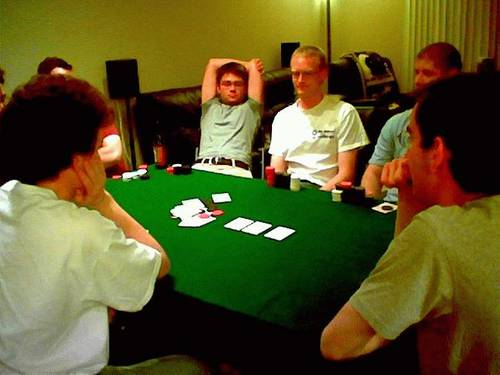

In [249]:
display(Image(filename))

In [250]:
print(get_image_caption(filename,model2))

 A A A A A A A 
